Reading data: /home/seyhankokcu/Development/TSA/predictive-maintenance-lstm/outputs/results.csv ...
Found Test Sets: [1 2 3]
✅ Graph generated: /home/seyhankokcu/Development/TSA/predictive-maintenance-lstm/figures/Visual_Report_Set_1.png


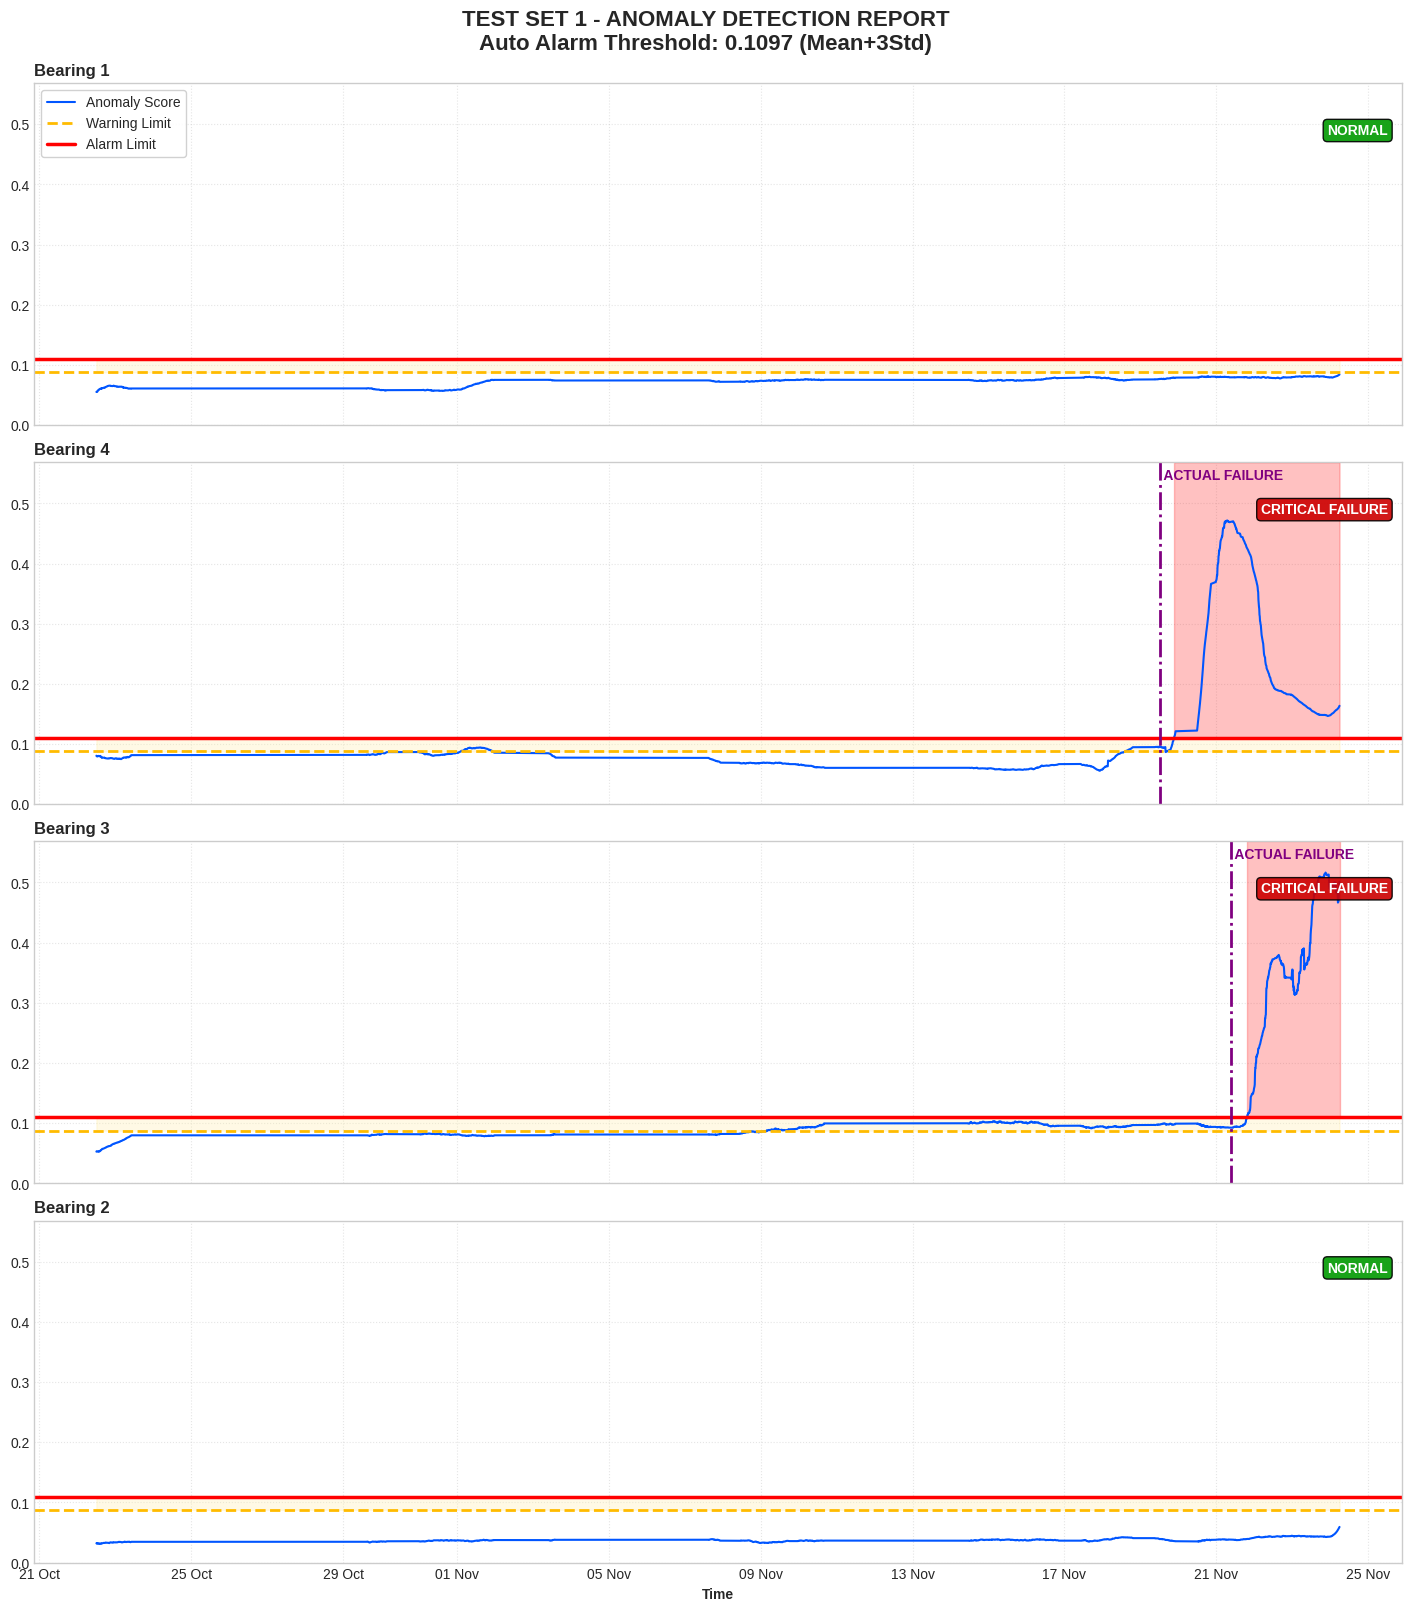

✅ Graph generated: /home/seyhankokcu/Development/TSA/predictive-maintenance-lstm/figures/Visual_Report_Set_2.png


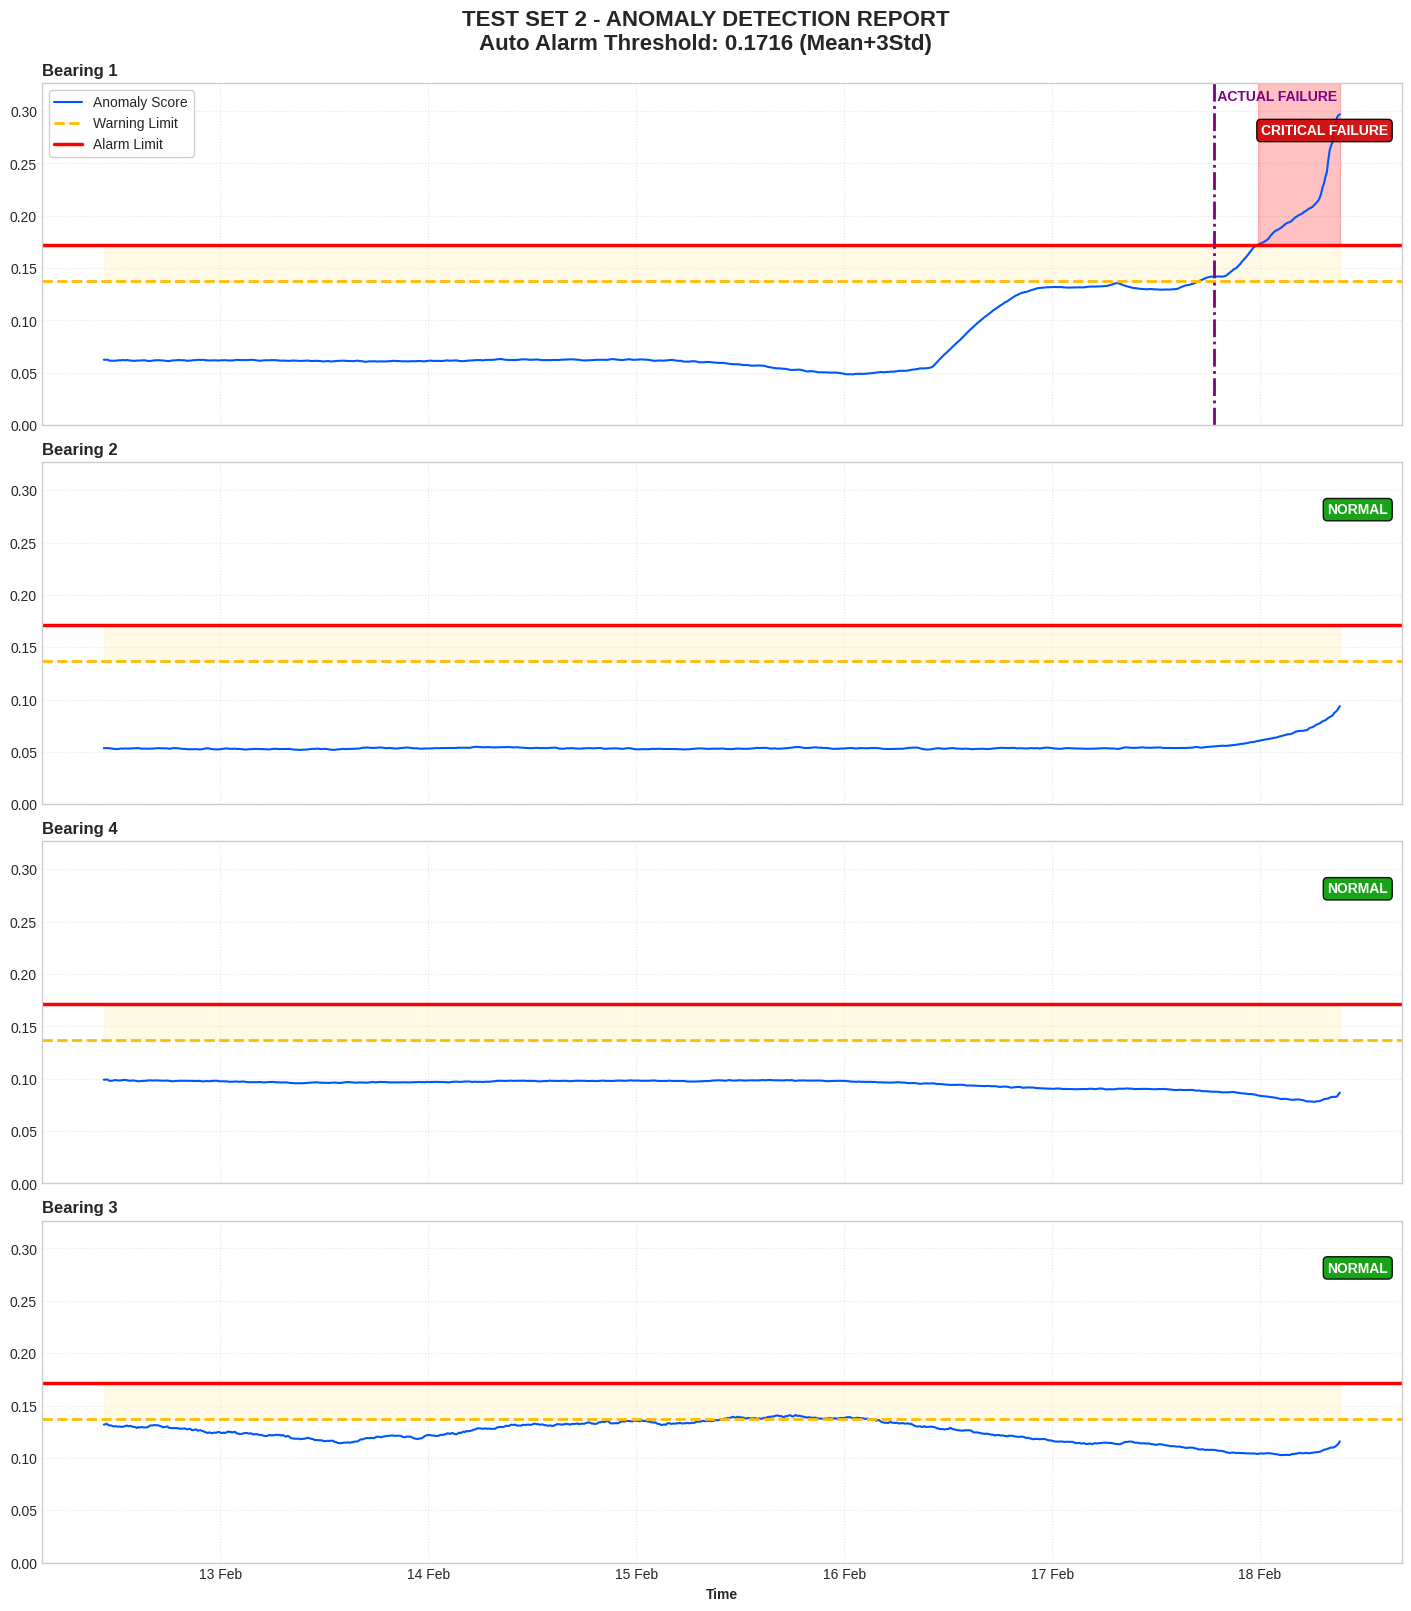

✅ Graph generated: /home/seyhankokcu/Development/TSA/predictive-maintenance-lstm/figures/Visual_Report_Set_3.png


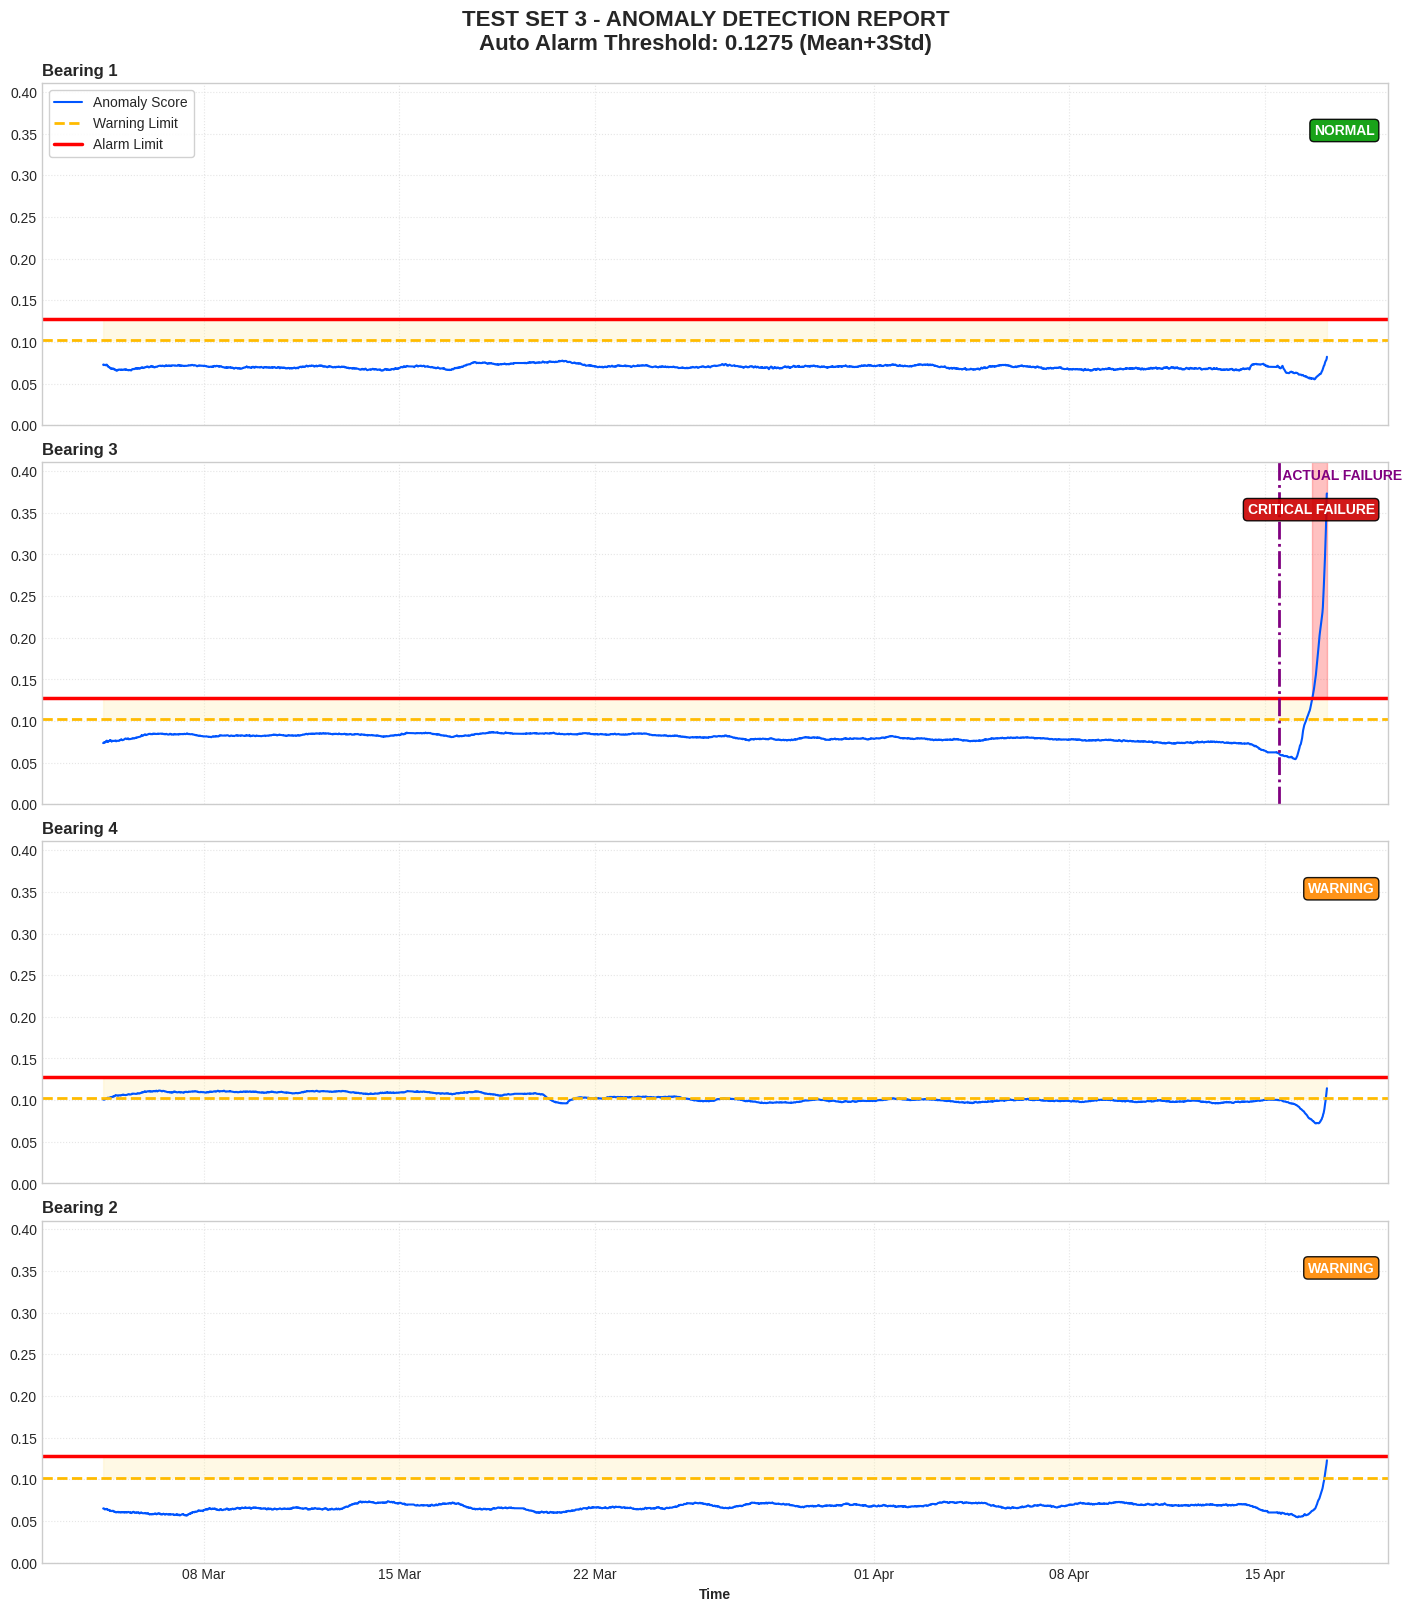

In [2]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from predictive_maintenance.config import Config

# Set global plot style
plt.style.use("seaborn-v0_8-whitegrid")

class IMSVisualizer:
    """
    Handles the visualization of anomaly detection results.
    Optimized for performance and minimal boilerplate.
    """

    def __init__(self):
        self.results_path = Config.RESULTS_SAVE_PATH

    def load_results(self) -> pd.DataFrame:
        """Loads results with optimized date parsing."""
        if not self.results_path.exists():
            raise FileNotFoundError(
                f"❌ Results file not found at: {self.results_path}\n"
                "Please run the evaluation script first."
            )

        # Parse dates directly during read for performance
        return pd.read_csv(self.results_path, parse_dates=["timestamp"])

    def calculate_dynamic_threshold(self, df: pd.DataFrame):
        """
        Calculates dynamic alarm thresholds using vectorized operations.
        """
        calibration_delta = pd.Timedelta(hours=Config.CALIBRATION_HOURS)
        safe_scores = []

        # GroupBy is faster than repeated boolean indexing
        for _, group in df.groupby("bearing_id"):
            limit_time = group["timestamp"].min() + calibration_delta
            # Vectorized filtering
            mask = group["timestamp"] < limit_time
            safe_scores.append(group.loc[mask, "anomaly_score"].to_numpy())

        if not safe_scores:
            return 0.5, 0.4

        # Concatenate once and calculate stats
        pool = np.concatenate(safe_scores)
        mean_val, std_val = np.mean(pool), np.std(pool)

        control_limit = mean_val + (3 * std_val)
        warning_limit = control_limit * (1 - Config.SECURITY_MARGIN)

        return control_limit, warning_limit

    def plot_experiment(self, df: pd.DataFrame, test_id: int):
        """
        Generates the anomaly detection plot efficiently.
        """
        # Create a view instead of copy where possible, but sort ensures linearity
        exp_df = df[df["test_id"] == test_id].sort_values("timestamp")

        if exp_df.empty:
            print(f"⚠️ Warning: No data found for Test ID {test_id}")
            return

        ALARM_LIMIT, WARNING_LIMIT = self.calculate_dynamic_threshold(exp_df)

        # Vectorized max calculation
        data_max = exp_df["anomaly_score"].max()
        Y_MAX = max(Config.FIXED_Y_LIMIT, data_max * 1.1, ALARM_LIMIT * 1.2)

        # Initialize plot with modern layout engine
        fig, axes = plt.subplots(4, 1, figsize=(14, 16), sharex=True, constrained_layout=True)

        fig.suptitle(
            f"TEST SET {test_id} - ANOMALY DETECTION REPORT\n"
            f"Auto Alarm Threshold: {ALARM_LIMIT:.4f} (Mean+3Std)",
            fontsize=16, fontweight="bold"
        )

        # Get unique bearings and ensure we iterate over axes safely
        bearings = exp_df["bearing_id"].unique()
        gt_dict = Config.GROUND_TRUTHS.get(test_id, {})

        for i, ax in enumerate(axes):
            if i >= len(bearings):
                ax.text(0.5, 0.5, "No Data", ha="center", color="gray", transform=ax.transAxes)
                ax.axis("off")
                continue

            b_id = bearings[i]
            data = exp_df[exp_df["bearing_id"] == b_id]
            timestamps = data["timestamp"]
            scores = data["anomaly_score"]

            # --- Main Plotting ---
            ax.plot(timestamps, scores, color="#0055ff", lw=1.5, label="Anomaly Score")
            ax.axhline(WARNING_LIMIT, color="#ffbb00", ls="--", lw=2, label="Warning Limit")
            ax.axhline(ALARM_LIMIT, color="#ff0000", ls="-", lw=2.5, label="Alarm Limit")

            # --- Areas ---
            ax.fill_between(timestamps, WARNING_LIMIT, ALARM_LIMIT, color="#ffeeaa", alpha=0.3)
            ax.fill_between(
                timestamps, ALARM_LIMIT, Y_MAX,
                where=(scores > ALARM_LIMIT),
                color="#ff3333", alpha=0.3, interpolate=True
            )

            # --- Status Label ---
            # Efficient tail check
            last_scores = scores.iloc[-10:] if len(scores) > 10 else scores
            recent_score = last_scores.mean()

            if recent_score > ALARM_LIMIT:
                status, color = "CRITICAL FAILURE", "#cc0000"
            elif recent_score > WARNING_LIMIT:
                status, color = "WARNING", "#ff8800"
            else:
                status, color = "NORMAL", "#009900"

            ax.text(
                0.99, 0.85, status, transform=ax.transAxes,
                ha="right", color="white", fontweight="bold",
                bbox=dict(facecolor=color, alpha=0.9, boxstyle="round,pad=0.3")
            )

            # --- Ground Truth ---
            if b_id in gt_dict:
                gt_date = pd.Timestamp(gt_dict[b_id])
                if timestamps.min() <= gt_date <= timestamps.max():
                    ax.axvline(gt_date, color="purple", ls="-.", lw=2)
                    ax.text(gt_date, Y_MAX * 0.95, " ACTUAL FAILURE",
                            color="purple", fontweight="bold", ha="left")

            # --- Styling ---
            ax.set_title(f"Bearing {b_id}", loc="left", fontweight="bold", fontsize=12)
            ax.set_ylim(0, Y_MAX)
            ax.grid(True, alpha=0.5, linestyle=":")

            if i == 0:
                ax.legend(loc="upper left", frameon=True, framealpha=0.9)

        # Common X-axis formatting
        axes[-1].xaxis.set_major_formatter(mdates.DateFormatter("%d %b"))
        axes[-1].set_xlabel("Time", fontweight="bold")

        # Save and Show
        save_name = Config.FIGURES_DIR / f"Visual_Report_Set_{test_id}.png"
        plt.savefig(save_name, dpi=300)
        print(f"✅ Graph generated: {save_name}")

        plt.show(block=False)
        plt.pause(1) # Brief pause to render without blocking
        plt.close(fig)

    def run(self):
        """Main execution flow."""
        print(f"Reading data: {self.results_path} ...")
        try:
            df = self.load_results()
        except FileNotFoundError as e:
            print(e)
            return

        unique_tests = df["test_id"].unique()
        unique_tests.sort() # In-place sort is faster
        print(f"Found Test Sets: {unique_tests}")

        for t_id in unique_tests:
            self.plot_experiment(df, test_id=t_id)

if __name__ == "__main__":
    IMSVisualizer().run()